In [271]:
import numpy as np
import pandas as pd
import json
import ast
import pymongo
from matplotlib import pyplot as plt
from clean_table import clean_individus, calculate_age, add_id_to_serie
path = '/media/flo/Stockage/Data/MesAides/tables/'

In [272]:
%qtconsole
%matplotlib inline

# Individus

Les individus ne sont pas uniquement des "demandeurs", ce sont aussi des enfants & conjoints. En fait, ce sont tous les "individus" qui peuvent figurer dans une simulation.

In [1155]:
t_individus = clean_individus()

/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py:3006: DtypeWarning: Columns (3,5,10,14,15,17,18,19,21,24,27,28,31,33,34,35,36,37,39,41,45,46,48,50,51,52,53,54) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [1156]:
t_individus.head(1)

,_id_individu,_id_demandeur,aCharge,assPreconditionRemplie,autoEntrepreneurActiviteType,autresRevenusTns,autresRevenusTnsActiviteType,autresRevenusTnsEmployes,boursier,boursierEnseignementSup,...,situationsPro,specificSituations,statusMarital,statutMarital,tauxIncapacite,tauxInvalidite,tnsActiviteType,tnsStructureType,villeNaissance,age
0,53cd46e76e5e3202000f4617,53cd46e76e5e3202000f4616,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,[],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,61


In [322]:
t_individus.dateDeNaissance.head()

0   1954-09-14
1   1984-09-14
2   1981-09-14
3   1982-09-14
4   1989-09-14
Name: dateDeNaissance, dtype: datetime64[ns]

### Missing values

In [283]:
individus_NA = t_individus.isnull().sum().reset_index()
individus_NA.columns = ['features', 'na']
individus_NA.set_index('features', inplace=True)

In [284]:
individus_NA.head(5)

,na
features,
_id,0
_id_demandeur,0
aCharge,39447
assPreconditionRemplie,186112
autoEntrepreneurActiviteType,73300


In [285]:
individus_NA['ratio'] = individus_NA['na'] / len(t_individus)

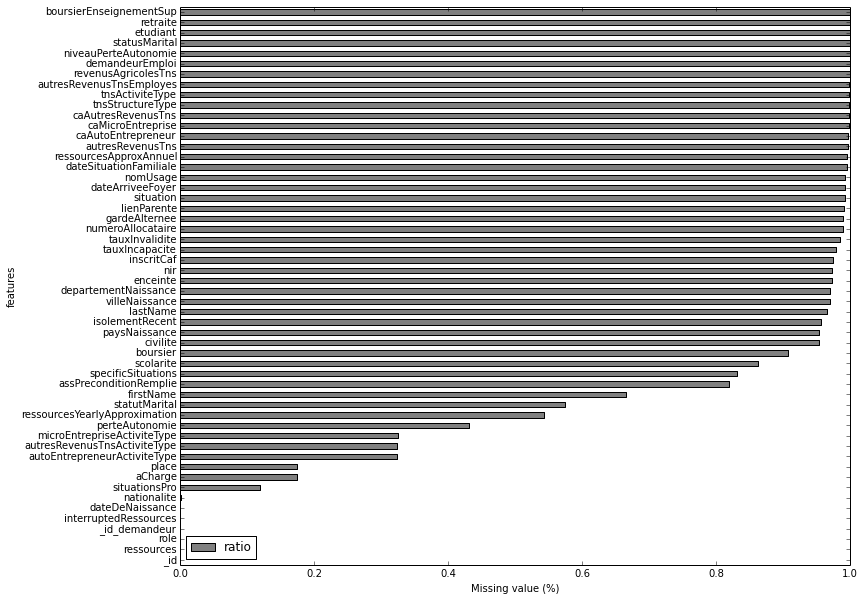

In [286]:
individus_NA.sort_values('ratio', ascending='False').plot(y= 'ratio', kind='barh', figsize=(12, 10), color='grey')
plt.xlabel('Missing value (%)')

### Enfant

In [287]:
grouped = t_individus.groupby('_id_demandeur')['role']

In [288]:
grouped.value_counts().head()

_id_demandeur             role     
53cd46e76e5e3202000f4616  demandeur    1
53cd48556e5e3202000f4624  demandeur    1
53d0c86489d7bd02003d8457  conjoint     1
                          demandeur    1
53d0d01889d7bd02003d84a1  enfant       2
dtype: int64

In [289]:
t_role = grouped.value_counts().reset_index()
t_role.columns = ['_id_demandeur', 'role', 'nb']
t_role = t_role[t_role.role != 'demandeur']
t_role.head(3)

,_id_demandeur,role,nb
2,53d0c86489d7bd02003d8457,conjoint,1
4,53d0d01889d7bd02003d84a1,enfant,2
6,53d0d35089d7bd02003d84a6,enfant,3


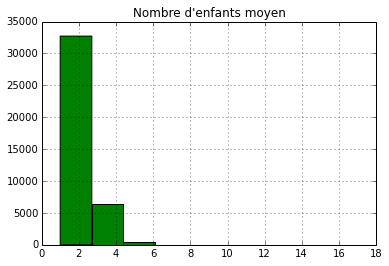

In [290]:
plt.subplot(111)
t_role[t_role.role == 'enfant']['nb'].hist(color='green')
plt.title('Nombre d\'enfants moyen')

### Situation pro

In [470]:
t_individus[['_id_individu', '_id_demandeur', 'situationsPro']].loc[200113:200114]

,_id_individu,_id_demandeur,situationsPro
200113,56fd555a91dac855400fd4ab,56fd555a91dac855400fd4a5,"[{'situation': 'demandeur_emploi', '_id': '56f..."
200114,56fd555a91dac855400fd4a9,56fd555a91dac855400fd4a5,"[{'situation': 'autre', '_id': '56fd555a91dac8..."


In [296]:
serie = situation_pro
k = 0
for list_ind in serie:
    if len(list_ind) > 0:
        for d in list_ind:
            d['_id'] = t_individus.iloc[k]._id
    else:
        pass
    k += 1

In [471]:
add_id_to_serie(t_individus, "situationsPro", "_id_individu", "_id_individu")

In [472]:
t_situations_pro = pd.DataFrame(t_individus.situationsPro.sum())

In [473]:
t_situations_pro.head(1)

,_id,_id_individu,situation
0,5422b60b5be58c0200a07549,5422b60b5be58c0200a07548,demandeur_emploi


In [474]:
t_situations_pro.columns = ['_id', '_id_individu', 'situationsPro']
t_situations_pro.head(1)

,_id,_id_individu,situationsPro
0,5422b60b5be58c0200a07549,5422b60b5be58c0200a07548,demandeur_emploi


In [1158]:
del t_individus['situationsPro']
t_individus = pd.merge(t_individus,
                       t_situations_pro[["_id_individu", "situationsPro"]],
                       on="_id_individu",
                       how="left")
t_individus.head(2)

,_id_individu,_id_demandeur,aCharge,assPreconditionRemplie,autoEntrepreneurActiviteType,autresRevenusTns,autresRevenusTnsActiviteType,autresRevenusTnsEmployes,boursier,boursierEnseignementSup,...,specificSituations,statusMarital,statutMarital,tauxIncapacite,tauxInvalidite,tnsActiviteType,tnsStructureType,villeNaissance,age,situationsPro
0,53cd46e76e5e3202000f4617,53cd46e76e5e3202000f4616,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,NaN
1,53cd48556e5e3202000f4625,53cd48556e5e3202000f4624,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,31,NaN


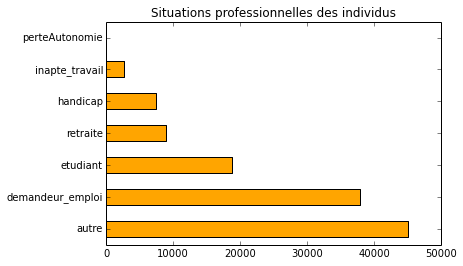

In [520]:
t_individus.situationsPro.value_counts().plot(kind='barh', color='orange')
plt.title('Situations professionnelles des individus')

### Age

#### Age = 0 

In [525]:
t_individus[t_individus.age == 0].ix[:, ['dateDeNaissance', 'age', '_id_demandeur']].head(5)

,dateDeNaissance,age,_id_demandeur
3220,2015-08-20,0,54fa2d46e33d9c7979b87724
4029,2015-10-01,0,54fde69b7f2195de05aaf6a2
4030,2015-10-01,0,54fde69b7f2195de05aaf6a2
4610,2015-10-21,0,5501447050a4762d5ab00058
5749,2015-10-10,0,55059f44ba0c71992f3bf5ee


#### Age > 120 

In [604]:
# Nombre d'individus avec age > 120
t_individus[t_individus.age > 120].age.count()

28

In [609]:
# Les individus avec age > 120
t_individus[t_individus.age > 120].age.sort_values(ascending=False)

4845      326
18967     325
12921     319
16033     223
9537      217
14164     161
5626      150
12085     146
8938      144
8941      144
13515     131
197938    130
221100    130
201157    128
111247    128
94803     128
230156    127
69989     126
113980    126
161959    126
18521     125
213699    124
46080     124
60110     123
174038    123
110254    121
157034    121
7305      121
Name: age, dtype: float64

#### Filtre sur l'age

In [1159]:
# -- On les enlèvve
t_individus = t_individus.loc[(t_individus.age > 0) & (t_individus.age < 120)]

#### Répartition

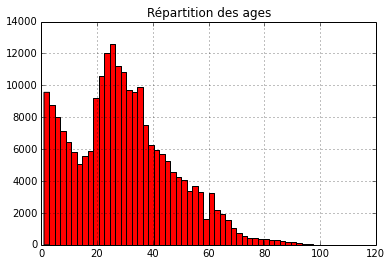

In [622]:
t_individus.age.hist(color='red', bins=60)
plt.title('Répartition des ages')

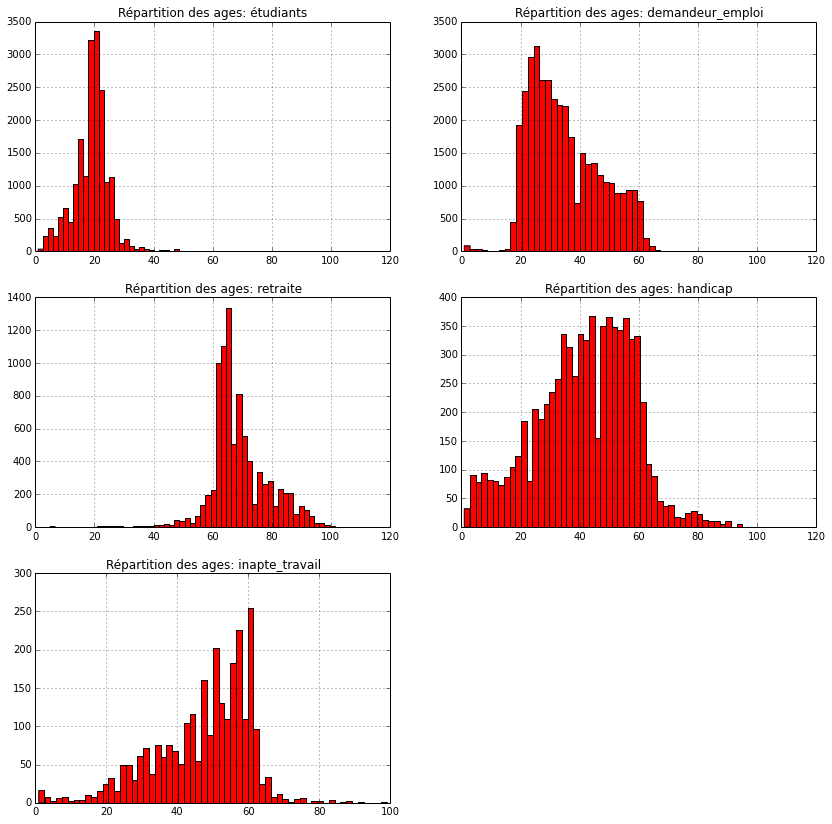

In [623]:
plt.figure(figsize=(14, 14))
plt.subplot(321)
t_individus[t_individus.situationsPro == 'etudiant'].age.hist(color='red', bins=60)
plt.title('Répartition des ages: étudiants')
plt.subplot(322)
t_individus[t_individus.situationsPro == 'demandeur_emploi'].age.hist(color='red', bins=60)
plt.title('Répartition des ages: demandeur_emploi')
plt.subplot(323)
t_individus[t_individus.situationsPro == 'retraite'].age.hist(color='red', bins=60)
plt.title('Répartition des ages: retraite')
plt.subplot(324)
t_individus[t_individus.situationsPro == 'handicap'].age.hist(color='red', bins=60)
plt.title('Répartition des ages: handicap')
plt.subplot(325)
t_individus[t_individus.situationsPro == 'inapte_travail'].age.hist(color='red', bins=60)
plt.title('Répartition des ages: inapte_travail')

(0, 100)

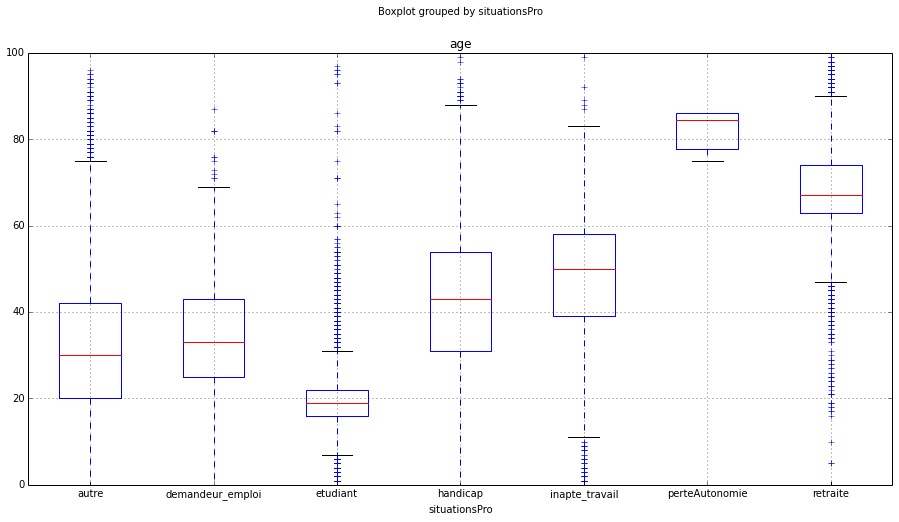

In [600]:
from matplotlib import gridspec
plt.figure(figsize=(15, 8))
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0])
# -- On filtre sur les individus ayant moins de 120 ans (enleve les outliers)
t_individus[t_individus.age < 120].boxplot(column=['age'], by='situationsPro', ax=ax1)
plt.ylim((0, 100))

#### enfant et -10 ans
Validity check

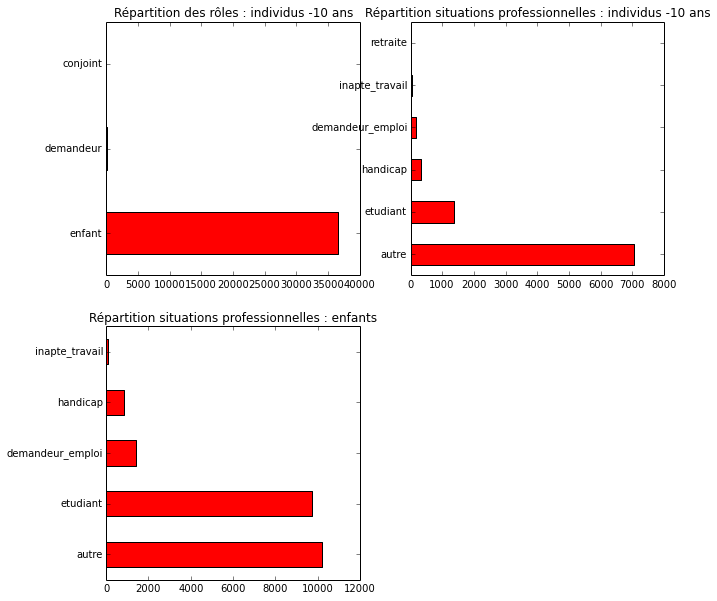

In [624]:
plt.figure(figsize=(10, 10))
plt.subplot(221)
t_individus[t_individus.age < 10].role.value_counts().plot(kind='barh', color='red')
plt.title('Répartition des rôles : individus -10 ans')
plt.subplot(222)
t_individus[t_individus.age < 10].situationsPro.value_counts().plot(kind='barh', color='red')
plt.title('Répartition situations professionnelles : individus -10 ans')
plt.subplot(223)
t_individus[t_individus.role == 'enfant'].situationsPro.value_counts().plot(kind='barh', color='red')
plt.title('Répartition situations professionnelles : enfants')


### Ressources

In [635]:
t_individus.ressources[0]

"[{'periode': '2014-04', '_id': ObjectId('54465def99337c9d5413681f'), 'montant': 720, 'type': 'revenusSalarie'}, {'periode': '2014-05', '_id': ObjectId('54465def99337c9d5413681e'), 'montant': 720, 'type': 'revenusSalarie'}, {'periode': '2014-06', '_id': ObjectId('54465def99337c9d5413681d'), 'montant': 720, 'type': 'revenusSalarie'}]"

In [632]:
t_individus_test = t_individus.copy()

In [644]:
t_individus_test.ressources =\
    t_individus_test.ressources.apply(
        lambda x: [] if (pd.isnull(x) or x == '[]') else x)

t_individus_test.ressources =\
    [ast.literal_eval(x.replace("ObjectId('", '\'').replace("')", '\''))
        if type(x) == str else x for x in t_individus_test.ressources]

In [645]:
add_id_to_serie(t_individus_test, 'ressources', '_id_individu', '_id_individu')

In [647]:
t_ressources.head()

,_id,_id_individu,montant,periode,type
0,54465def99337c9d5413681f,53cd46e76e5e3202000f4617,720,2014-04,revenusSalarie
1,54465def99337c9d5413681e,53cd46e76e5e3202000f4617,720,2014-05,revenusSalarie
2,54465def99337c9d5413681d,53cd46e76e5e3202000f4617,720,2014-06,revenusSalarie
3,54465def99337c9d54136822,53cd48556e5e3202000f4625,800,2014-04,revenusSalarie
4,54465def99337c9d54136821,53cd48556e5e3202000f4625,800,2014-05,revenusSalarie


In [648]:
t_ressources.to_csv(path + 't_ressources.csv')

In [652]:
t_ressources.drop('_id', axis=1, inplace=True)

In [1160]:
## -- Merge
t_individus = pd.merge(t_individus,
                       t_ressources,
                       on="_id_individu",
                       how="left")
t_individus.head(2)

,_id_individu,_id_demandeur,aCharge,assPreconditionRemplie,autoEntrepreneurActiviteType,autresRevenusTns,autresRevenusTnsActiviteType,autresRevenusTnsEmployes,boursier,boursierEnseignementSup,...,tauxIncapacite,tauxInvalidite,tnsActiviteType,tnsStructureType,villeNaissance,age,situationsPro,montant,periode,type
0,53cd46e76e5e3202000f4617,53cd46e76e5e3202000f4616,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,61,NaN,720,2014-04,revenusSalarie
1,53cd46e76e5e3202000f4617,53cd46e76e5e3202000f4616,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,61,NaN,720,2014-05,revenusSalarie


In [688]:
t_ressources.head()

,_id_individu,montant,periode,type
0,53cd46e76e5e3202000f4617,720,2014-04,revenusSalarie
1,53cd46e76e5e3202000f4617,720,2014-05,revenusSalarie
2,53cd46e76e5e3202000f4617,720,2014-06,revenusSalarie
3,53cd48556e5e3202000f4625,800,2014-04,revenusSalarie
4,53cd48556e5e3202000f4625,800,2014-05,revenusSalarie


# Import des tables

In [699]:
from pymongo import MongoClient
import bson
client = MongoClient('localhost', 27017)
db = client['MesAides']
collection = db['situations']
input_data = db.situations
data = pd.DataFrame(list(input_data.find()))

In [745]:
t_simultation = data.copy()

In [746]:
t_simultation.dateDeValeur = pd.to_datetime(t_simultation.dateDeValeur)

In [748]:
t_simultation = t_simultation.loc[t_simultation.dateDeValeur >= '01-01-2015']

In [749]:
t_simultation._id = t_simultation._id.astype(str)

In [666]:
t_patrimoines = pd.read_csv(path + 'patrimoines.csv')

In [1048]:
t_logements = pd.read_csv(path + 'logements.csv')

/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (2,6,7,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Clean des tables
### sur 2015

In [820]:
id_demandeurs_2015 = pd.unique(t_simultation._id).tolist()

In [1161]:
t_individus = t_individus.loc[t_individus._id_demandeur.isin(id_demandeurs_2015)]

In [1162]:
t_individus['type'] = t_individus['type'].astype(str)

In [1163]:
t_individus['type'] = t_individus['type'].replace('nan', np.nan)

In [1164]:
t_individus = t_individus.rename(columns = {'montant': 'ressources_montant',
                                            'periode': 'ressources_periode',
                                            'type': 'ressources_type'})

In [1280]:
t_individus.statutMarital = t_individus.statutMarital.astype(str)
t_individus.statutMarital = t_individus.statutMarital.replace('nan', np.nan)

### Pourcentages de simulations avec au moins une déclaration commençant par 'rnc_'

25,6 % des simulations contiennent au moins 1 rnc

In [784]:
t_simultation.head(2)

,__v,_id,_updated,dateDeValeur,email,individus,logement,mobilierValue,patrimoine,phoneNumber,ressourcesYearMoins2Captured,rfr,status,token
414,1,54abaf5ed20bc238169b42a0,NaN,2015-01-06 09:48:14.922,NaN,"[{'ressources': [], '_id': 54abaf5ed20bc238169...","{'membreFamilleProprietaire': False, 'adresse'...",NaN,"{'epargneSurLivret': 0, 'valeurLocativeImmoNon...",NaN,False,NaN,test,8bx6BuVVD-WrlM-k_1M7kaa3Ycv339XLJLY6KV7lc2A99h...
485,1,54abb15f608e752d1629e1e0,NaN,2015-01-06 09:56:47.892,NaN,"[{'ressources': [], '_id': 54abb15f608e752d162...","{'membreFamilleProprietaire': False, 'adresse'...",NaN,"{'epargneSurLivret': 0, 'valeurLocativeImmoNon...",NaN,False,NaN,test,pMmisXLdOw1bVc6_5uwZtCeJnllZXr02fgd_kITy38ftvw...


In [823]:
start_with_rnc = [x for x in t_individus['type'] if (x.startswith('rnc') == True)]

In [826]:
start_with_rnc[:5]

['rncRevenusActivite',
 'rncAutresRevenus',
 'rncPensionsRetraitesRentes',
 'rncPensionsAlimentaires',
 'rncPensionsAlimentairesVersees']

In [827]:
demandeurs_au_moins_1rnc = pd.unique(t_individus[t_individus.type.isin(start_with_rnc)]._id_demandeur).tolist()

In [828]:
# -- Simulation avec au moins 1 rnc
t_simultation[t_simultation._id.isin(demandeurs_au_moins_1rnc)].shape  # 28138

(28138, 14)

In [829]:
t_simultation.shape  # 109715

(109715, 14)

In [830]:
28138/109715

0.25646447614273343

### Répartition des types de ressources par individu
Remarque : attention, un individu peut avori plusieurs type de ressources.

In [840]:
t_individus.type.value_counts()

revenusSalarie                    1023096
allocationsChomage                 287148
pensionsAlimentairesVersees        191532
pensionsRetraitesRentes            141396
aide_logement                      128628
af                                 109944
nan                                 94455
pensionsAlimentaires                75564
pensionsInvalidite                  71136
rsa                                 61824
ass                                 55416
aah                                 50220
paje_base                           48324
indJourMaladie                      40284
rncRevenusActivite                  35604
bourseEnseignementSup               33804
revenusStageFormationPro            32076
caAutoEntrepreneur                  31752
stage                               28572
asf                                 21624
indJourMaternite                    20532
clca                                20100
cf                                  20076
rncAutresRevenus                  

In [918]:
t = t_individus.loc[(~t_individus.type.isin(start_with_rnc)) & (t_individus['type'].isnull() == False)]

In [919]:
t_count = t.groupby('_id_individu')['type'].value_counts()

In [926]:
t_count = t_count.reset_index()
t_count.columns = ['_id_individu_grouped', 'type', 'count']
t_count.head()

,_id_individu_grouped,type,count
0,54ad0c4f638f222b16b10a8e,revenusSalarie,12
1,54ad4354638f222b16b112b1,revenusSalarie,12
2,54ad4354638f222b16b112be,revenusSalarie,12
3,54ad4354638f222b16b112cb,revenusSalarie,12
4,54ad4354638f222b16b112d8,revenusSalarie,12


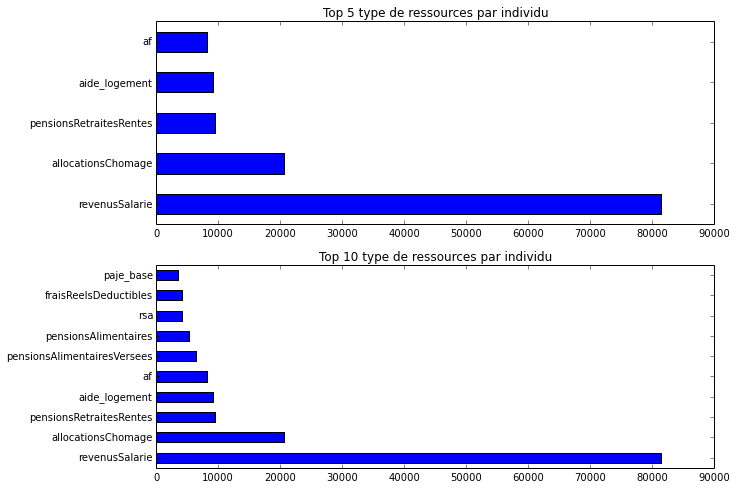

In [951]:
plt.figure(figsize=(10, 8))
plt.subplot(211)
t_count['type'].value_counts()[:5].plot(kind='barh')
plt.title('Top 5 type de ressources par individu')
plt.subplot(212)
t_count['type'].value_counts()[:10].plot(kind='barh')
plt.title('Top 10 type de ressources par individu')


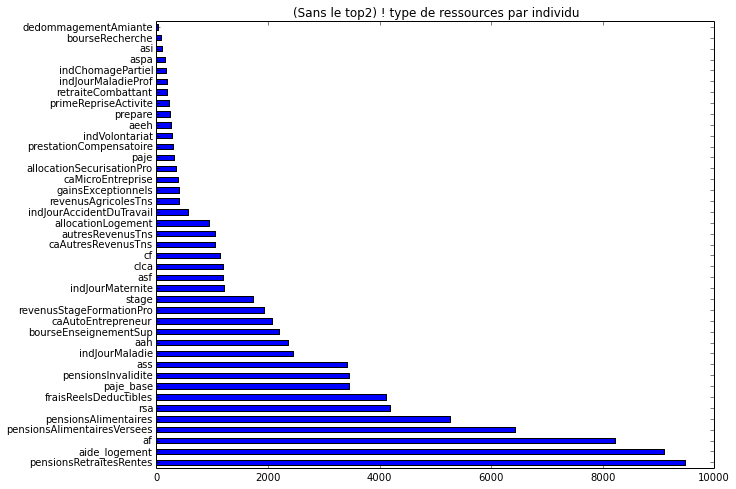

In [954]:
plt.figure(figsize=(10, 8))
t_count['type'].value_counts()[2:].plot(kind='barh')
plt.title('(Sans le top2) ! type de ressources par individu')

# Répartition des codes postaux

In [1049]:
t_logements.adresse = t_logements.adresse.apply(lambda x: [] if (pd.isnull(x) or x == '[]') else x)
t_logements.adresse = [ast.literal_eval(x) if type(x) == str else x for x in t_logements.adresse]
t_logements.adresse = t_logements.adresse.apply(lambda x: [x] if type(x) != list else x)

In [1050]:
del t_logements['Unnamed: 0']

In [1051]:
t_logements._id_demandeur = t_logements._id_demandeur.astype('str')

In [1052]:
t_logements.head(2)

,adresse,adresseConjoint,charges,codePostal,colocation,conjointMemeAdresse,dateArrivee,inhabitantForThreeYearsOutOfLastFive,isChambre,locationType,loyer,membreFamilleProprietaire,participationFrais,pretConventionne,primoAccedant,type,_id_demandeur
0,[{'codePostal': '123'}],NaN,NaN,123,NaN,NaN,NaN,NaN,NaN,NaN,123,True,NaN,NaN,NaN,locataire,53cd46e76e5e3202000f4616
1,[{'codePostal': '97400'}],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123,NaN,NaN,NaN,False,proprietaire,53cd48556e5e3202000f4624


In [1038]:
t_logements.shape

(110199, 17)

In [1053]:
add_id_to_serie(t_logements, 'adresse', '_id_demandeur', '_id_demandeur')

In [1039]:
t_adresses = pd.DataFrame(t_logements.adresse.sum())

In [1042]:
t_adresses.head(1)

,_id_demandeur,adresse,codeInsee,codePostal,nomCommune,ville
0,53cd46e76e5e3202000f4616,NaN,NaN,123,NaN,NaN


In [1043]:
t_adresses.to_csv(path + 'adresses.csv')

In [1054]:
del t_logements['adresse']
del t_logements['codePostal']

In [1055]:
t_logements = pd.merge(t_adresses, t_logements, on='_id_demandeur', how='right')

In [1084]:
t_logements = t_logements.loc[(t_logements.loyer != 123) & (t_logements.codePostal != '12345')]

In [1085]:
t_logements.head(4)

,_id_demandeur,adresse,codeInsee,codePostal,nomCommune,ville,adresseConjoint,charges,colocation,conjointMemeAdresse,dateArrivee,inhabitantForThreeYearsOutOfLastFive,isChambre,locationType,loyer,membreFamilleProprietaire,participationFrais,pretConventionne,primoAccedant,type
23,53d66986be4dbe020042bdd5,NaN,NaN,75011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nonmeuble,50,False,NaN,NaN,NaN,locataire
27,53d79969f6aa390200a6ccff,NaN,NaN,92500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nonmeuble,499,False,NaN,NaN,NaN,locataire
28,53d79a06f6aa390200a6cd09,NaN,NaN,92500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,heberge
29,53d79b10f6aa390200a6cd0d,NaN,NaN,92500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,heberge


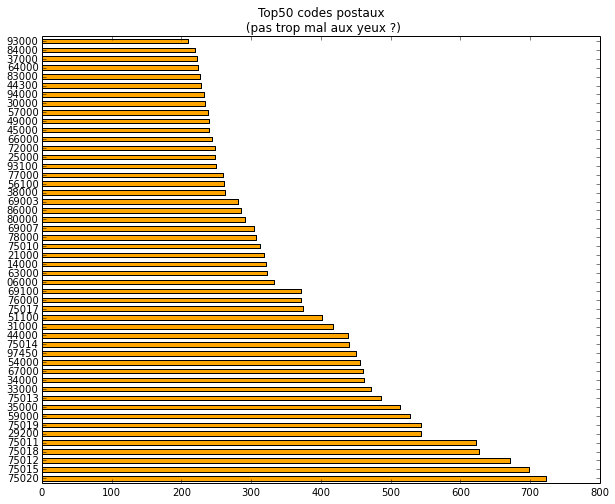

In [1086]:
# -- Répartition des codes 50
plt.figure(figsize=(10, 8))
t_logements.codePostal.value_counts()[:50].plot(kind='barh', color='orange')
plt.title('Top50 codes postaux \n (pas trop mal aux yeux ?)')

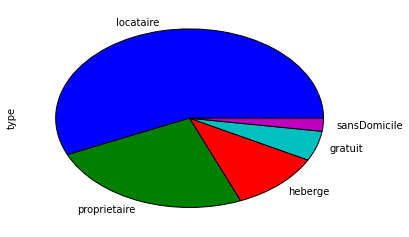

In [1087]:
t_logements.type.value_counts().plot.pie()

In [1093]:
loyers = t_logements.loyer.dropna().astype(int)

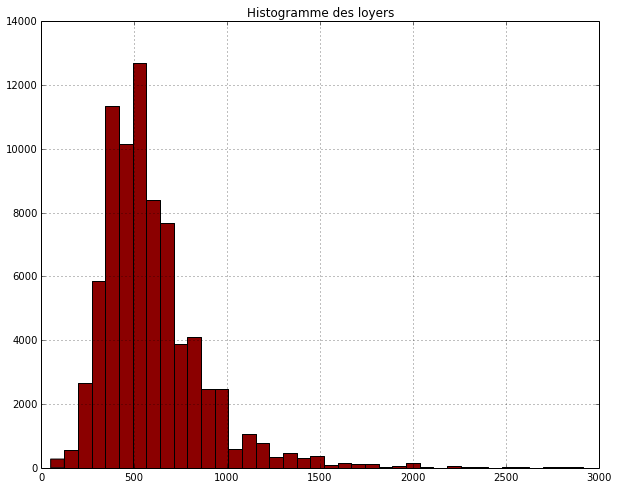

In [1138]:
plt.figure(figsize=(10, 8))
loyers.loc[(loyers > 50) & (loyers < 3000)].hist(bins=40, color='darkred')
plt.title("Histogramme des loyers")

# Ressources négatives

 * __Individu totaux (en comptant les enfants/conjoints)__
 
10.59% des individus contiennent au moins une ressource avec une valeur négative

 * __Individu "demandeur" (role) __
 
15.76% des individus "demandeur" contiennent au moins une ressource avec une valeur négative


In [1179]:
# individu unique
len(pd.unique(t_individus._id_individu).tolist())

222124

In [1177]:
# individu unique ayant au moins une ressource négative
len(pd.unique(t_individus[t_individus.ressources_montant < 0]._id_individu).tolist())

23513

In [1181]:
23513/222124

0.10585528803731249

In [1187]:
# individu "demandeur" unique
len(pd.unique(t_individus[t_individus.role == 'demandeur']._id_individu).tolist())

109561

In [1189]:
len(pd.unique(t_individus[(t_individus.role == 'demandeur') & (t_individus.ressources_montant < 0)]._id_individu).tolist())

17268

In [1190]:
17268/109561

0.15761082867078613

# Date plot

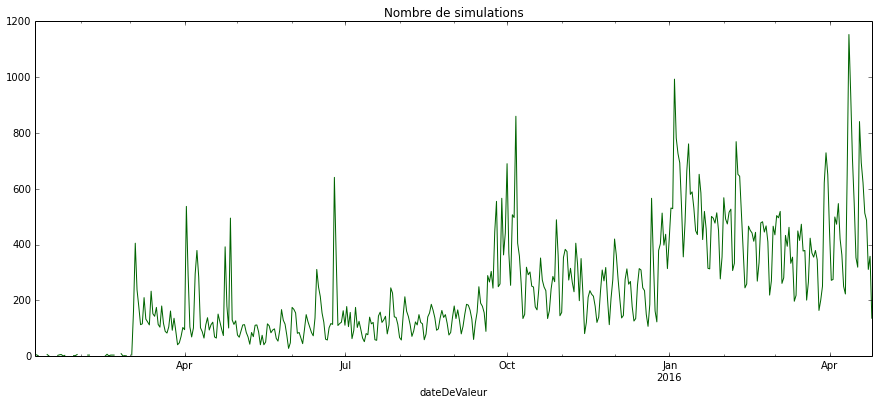

In [1216]:
t_date.resample('1d', how='sum')['temp'].plot(figsize=(15,6), color='darkgreen')
plt.title('Nombre de simulations')

# Type de famille

In [1251]:
%qtconsole

In [1255]:
t_individus.statutMarital.value_counts()

mariage              994431
union_libre          422415
pacs                 170822
relation_libre        62964
celibataire           30493
divorce               11547
separe                 5589
concubinage_rompu      3075
veuf                   2385
pacs_rompu              655
Name: statutMarital, dtype: int64

In [1256]:
statutMarital_valides = t_individus.statutMarital.value_counts().reset_index()['index'].tolist()

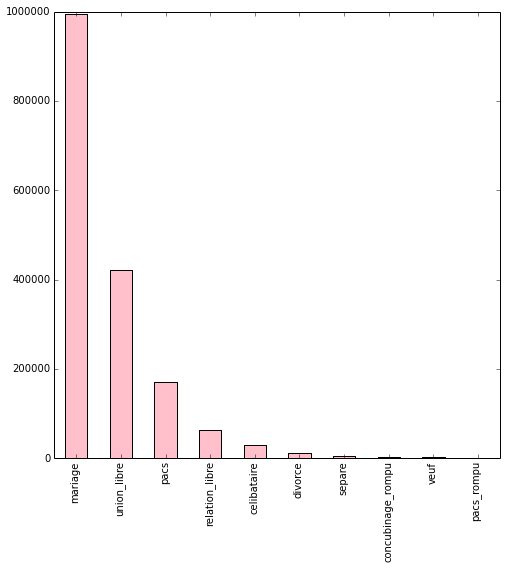

In [1268]:
t_individus.statutMarital[t_individus.statutMarital.isin(statutMarital_valides)].value_counts().plot(kind='bar', color='pink', figsize=(8, 8))

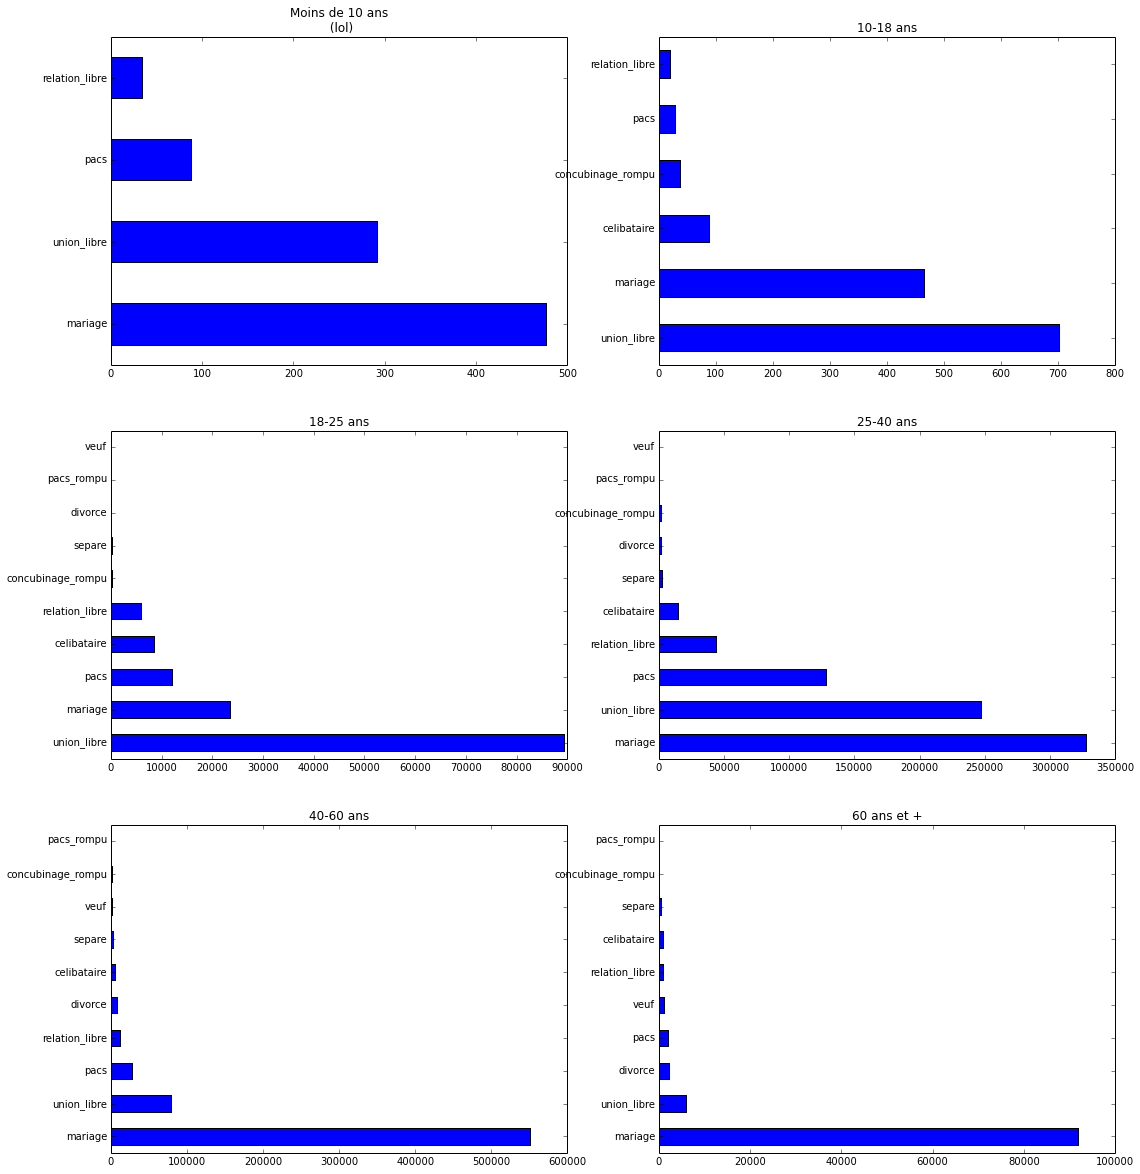

In [1305]:
plt.figure(figsize=(18,20))
plt.subplot(321)
t_individus.statutMarital[t_individus.age.isin(range(0, 10))].value_counts().plot(kind='barh')
plt.title('Moins de 10 ans \n (lol)')
plt.subplot(322)
t_individus.statutMarital[t_individus.age.isin(range(10, 18))].value_counts().plot(kind='barh')
plt.title('10-18 ans')
plt.subplot(323)
t_individus.statutMarital[t_individus.age.isin(range(18, 25))].value_counts().plot(kind='barh')
plt.title('18-25 ans')
plt.subplot(324)
t_individus.statutMarital[t_individus.age.isin(range(25, 40))].value_counts().plot(kind='barh')
plt.title('25-40 ans')
plt.subplot(325)
t_individus.statutMarital[t_individus.age.isin(range(40, 60))].value_counts().plot(kind='barh')
plt.title('40-60 ans')
plt.subplot(326)
t_individus.statutMarital[t_individus.age.isin(range(60, 150))].value_counts().plot(kind='barh')
plt.title('60 ans et +')